In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from collections import Counter
from statsmodels.tsa.api import ExponentialSmoothing

In [ ]:
train_visual = pd.read_csv('Data/yds_train2018.csv')
test_visual = pd.read_csv('Data/yds_test2018.csv')

In [ ]:
train_visual.shape,test_visual.shape

In [ ]:
train_visual.head()

In [ ]:
test_visual.head()

In [ ]:
train_visual = train_visual.groupby(['Year','Month','Product_ID','Country'],as_index=False).agg({'Sales':'sum'})

In [ ]:
from numba import jit
import math

@jit
def smape_fast(y_true=None, y_pred=None):
    out = 0
    for i in range(y_true.shape[0]):
        a = y_true[i]
        b = math.fabs(y_pred[i])
        c = a+b
        if c == 0:
            continue
        out += math.fabs(a - b) / c
    out *= (100.0 / y_true.shape[0])
    return out

def smape(pred,dtrain):
    label = np.array(dtrain.get_label())
    return 'smape',smape_fast(label,pred)
    

In [ ]:
test_visual['Sales'] = 0

train_visual['Year'] = train_visual['Year'].apply(lambda x : str(x))
train_visual['Month'] = train_visual['Month'].apply(lambda x : str(x))

test_visual['Year'] = test_visual['Year'].apply(lambda x : str(x))
test_visual['Month'] = test_visual['Month'].apply(lambda x : str(x))

train_visual['date'] = pd.to_datetime(train_visual['Year']+'-'+train_visual['Month']+'-'+str(1))
test_visual['date'] = pd.to_datetime(test_visual['Year']+'-'+test_visual['Month']+'-'+str(1))

train_visual.rename(columns={'Sales':'y','date':'ds'},inplace=True)
test_visual.rename(columns={'Sales':'y','date':'ds'},inplace=True)

In [30]:
from statsmodels import api as sm

Product_ID :  1    Country :  Argentina


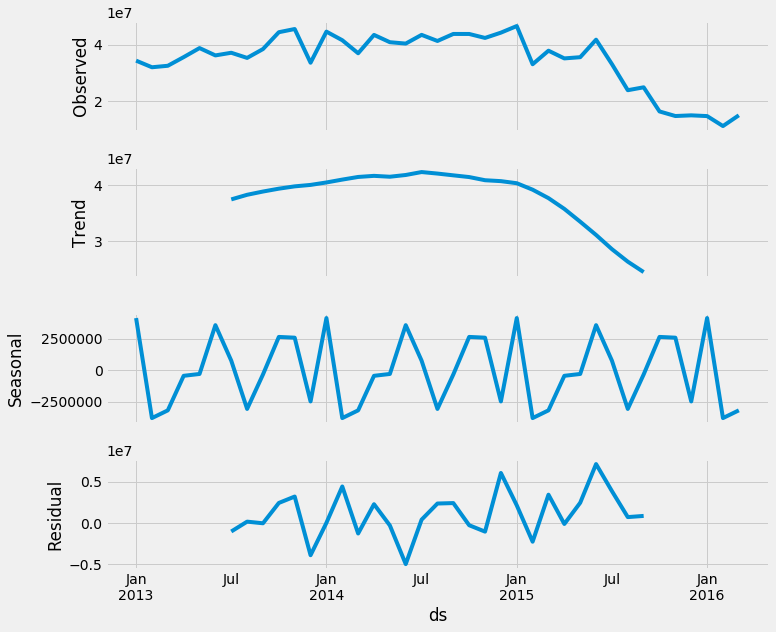

Product_ID :  1    Country :  Columbia


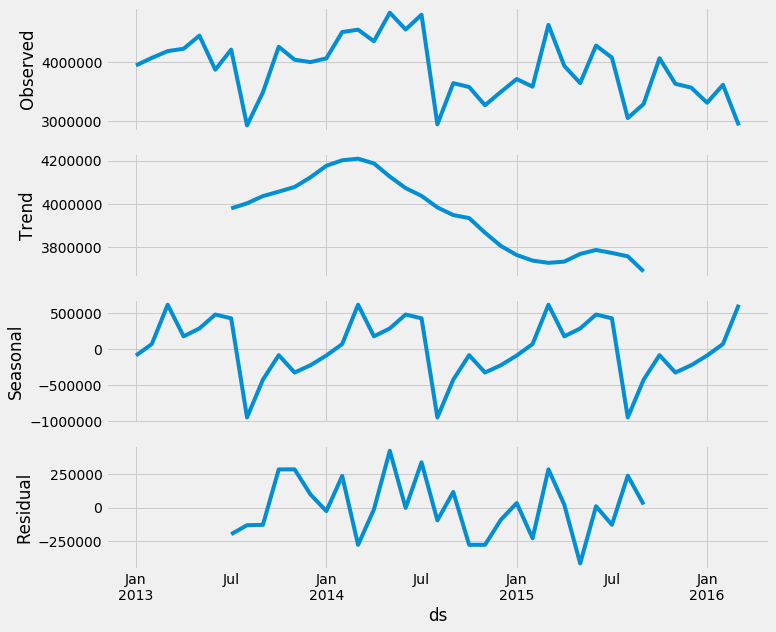

Product_ID :  2    Country :  Belgium


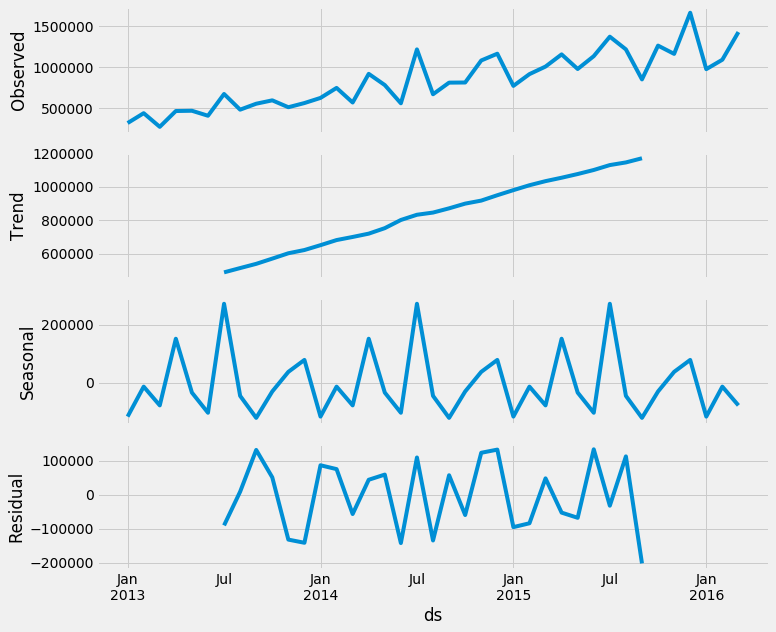

Product_ID :  2    Country :  Denmark


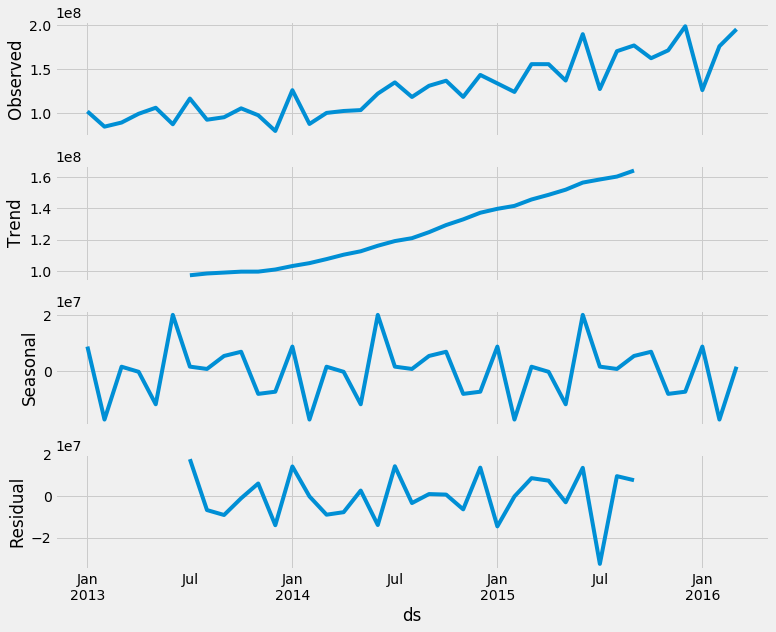

Product_ID :  2    Country :  Argentina


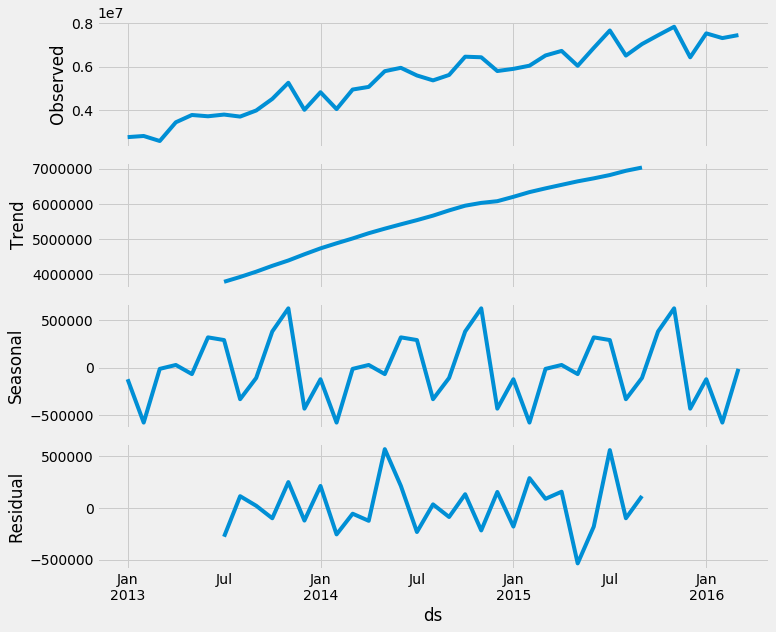

Product_ID :  2    Country :  Columbia


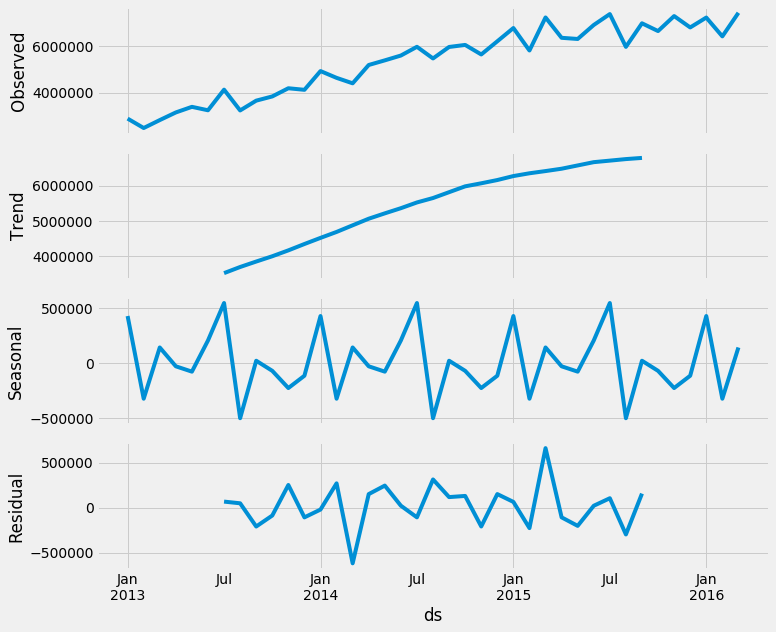

Product_ID :  3    Country :  Argentina


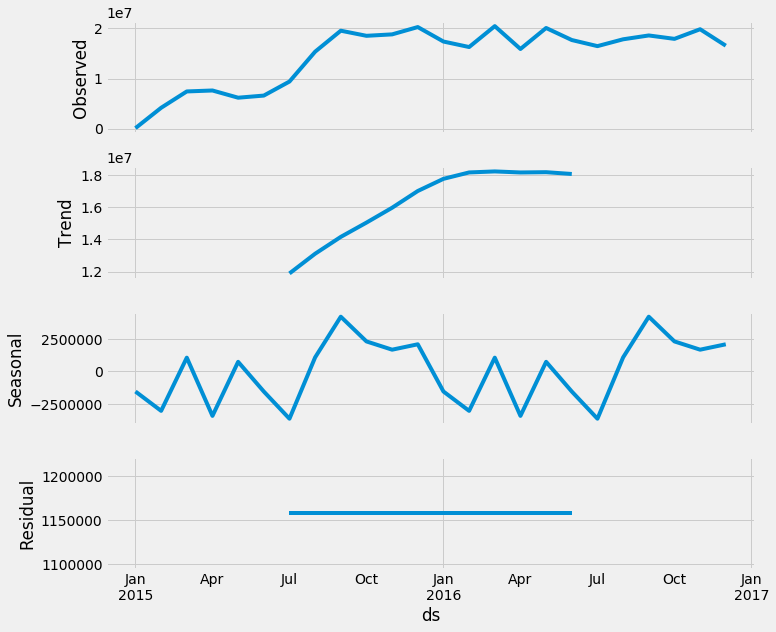

Product_ID :  3    Country :  Columbia


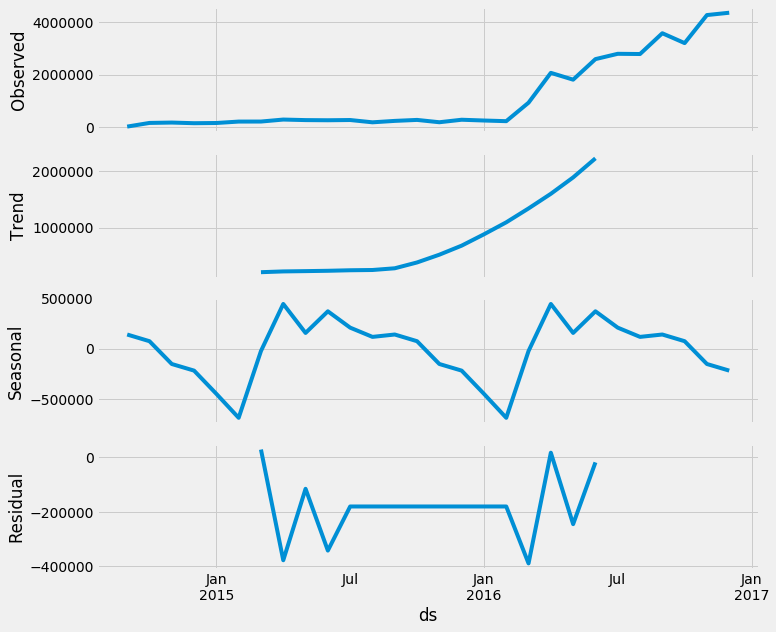

Product_ID :  4    Country :  Finland


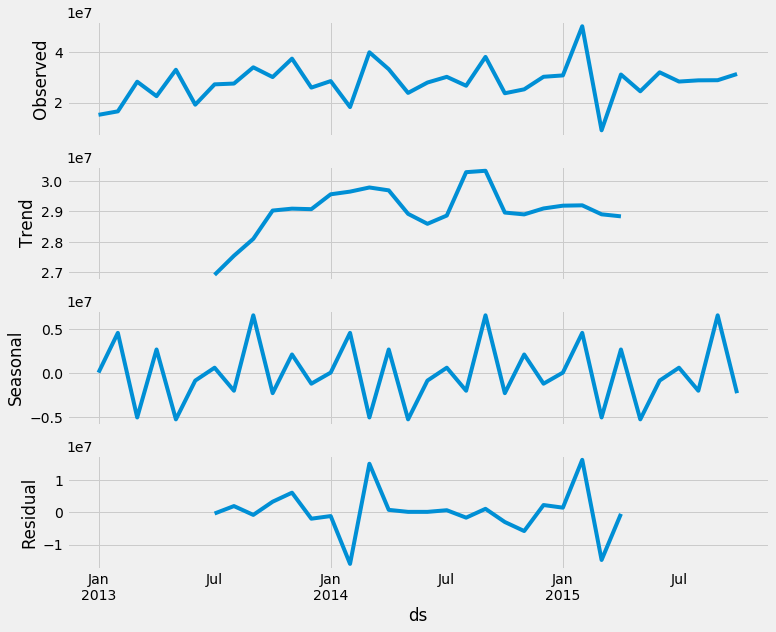

Product_ID :  4    Country :  England


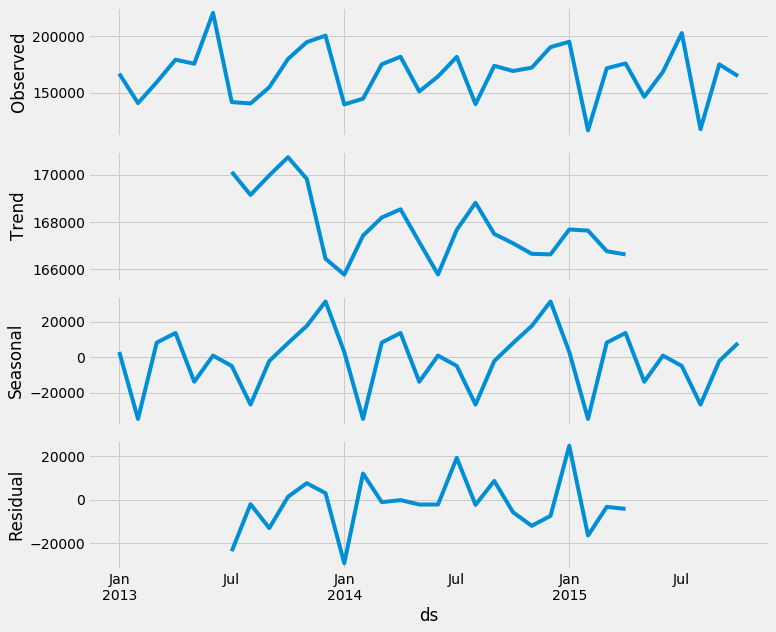

Product_ID :  5    Country :  England


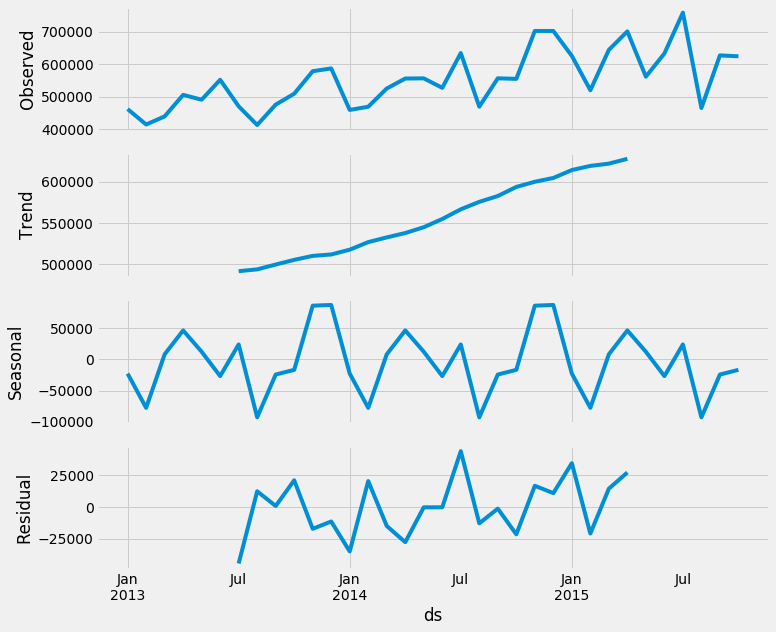

In [19]:
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9

for i in range(1,len(set(train_visual['Product_ID']))+1):
    tmp = list(set(train_visual[train_visual['Product_ID']==i]['Country']))
    for j in tmp:
        print('Product_ID : ',i,'  ','Country : ',j)
        decomposition = sm.tsa.seasonal_decompose(train_visual[(train_visual['Product_ID']==i)&(train_visual['Country']==j)].sort_values(['ds']).set_index('ds')['y'], model='additive')
        fig = decomposition.plot()
        plt.show()

In [32]:
import warnings
import itertools
plt.style.use('fivethirtyeight')

In [36]:
result = pd.DataFrame()

Product_ID :  1    Country :  Argentina


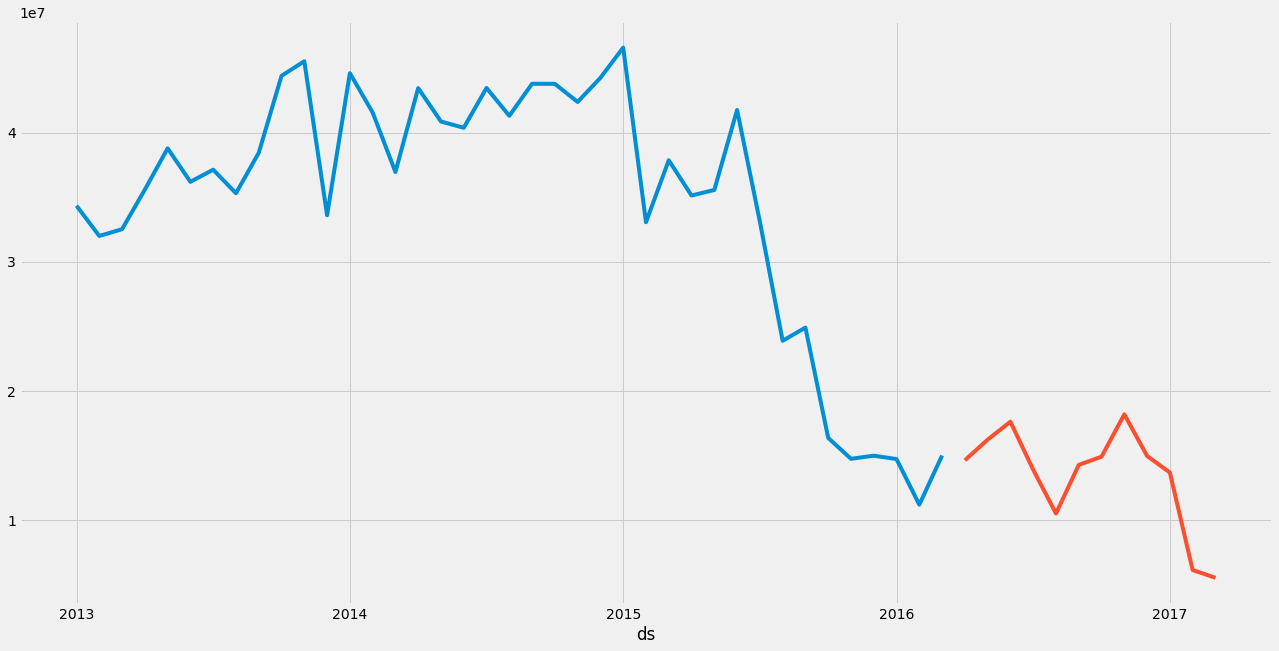

Product_ID :  1    Country :  Columbia


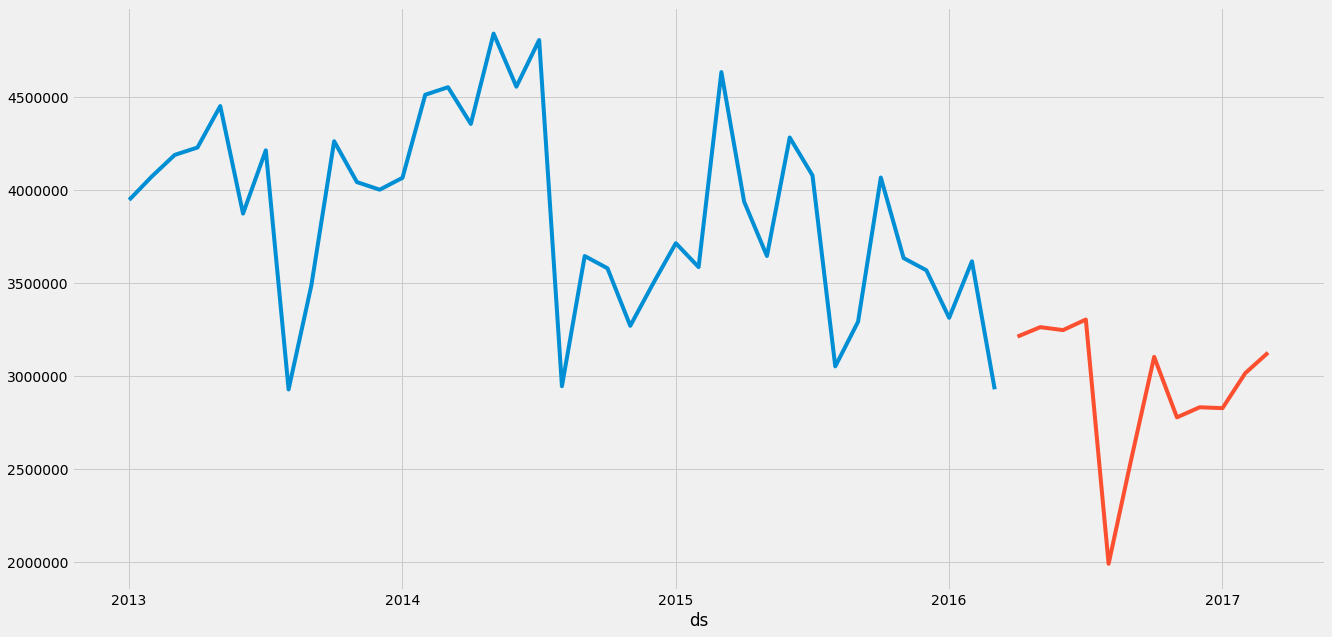

Product_ID :  2    Country :  Belgium


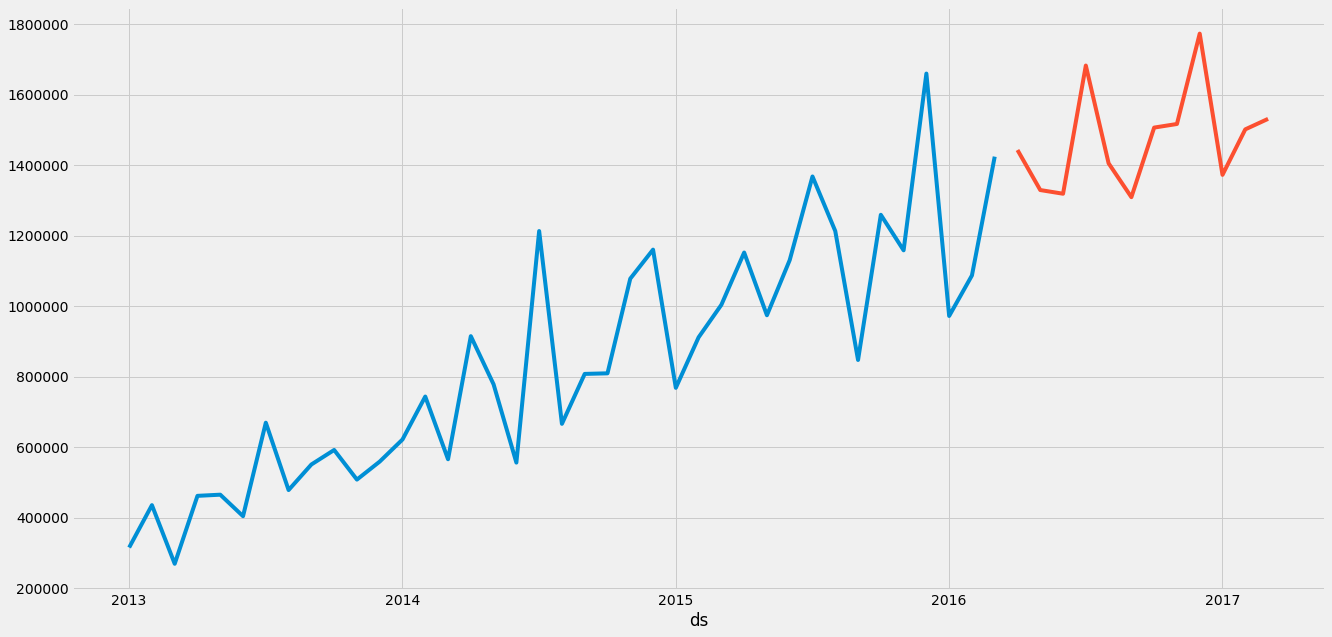

Product_ID :  2    Country :  Denmark


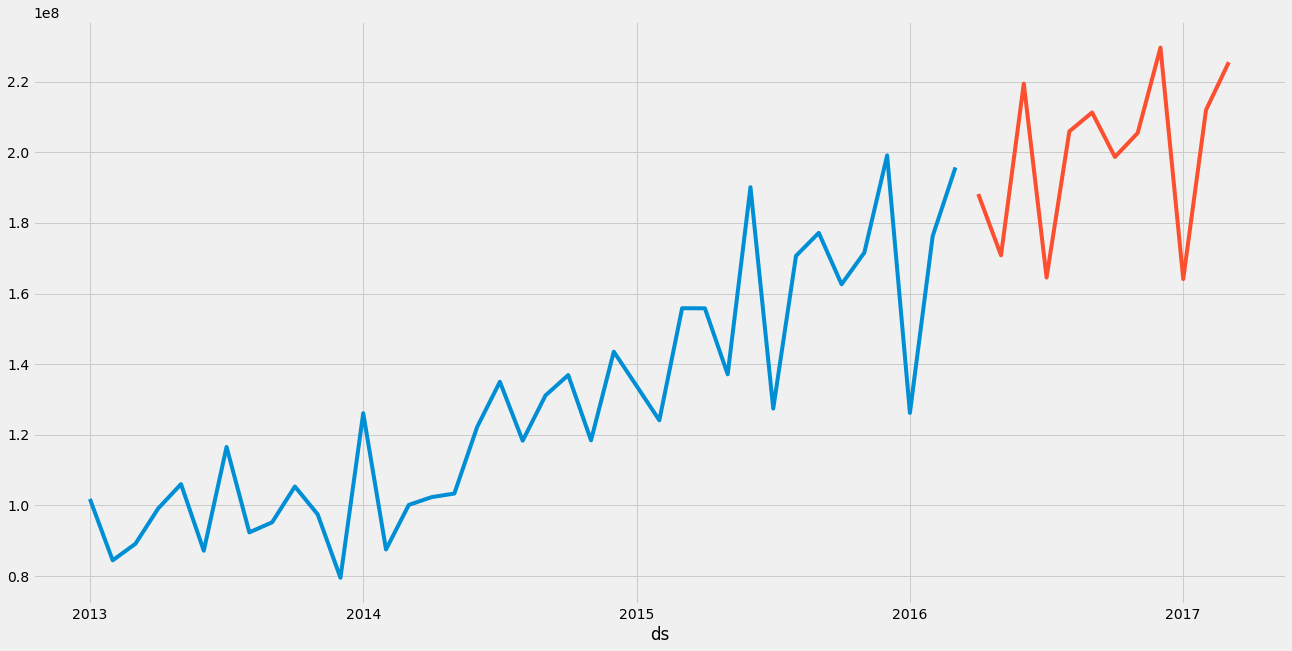

Product_ID :  2    Country :  Argentina


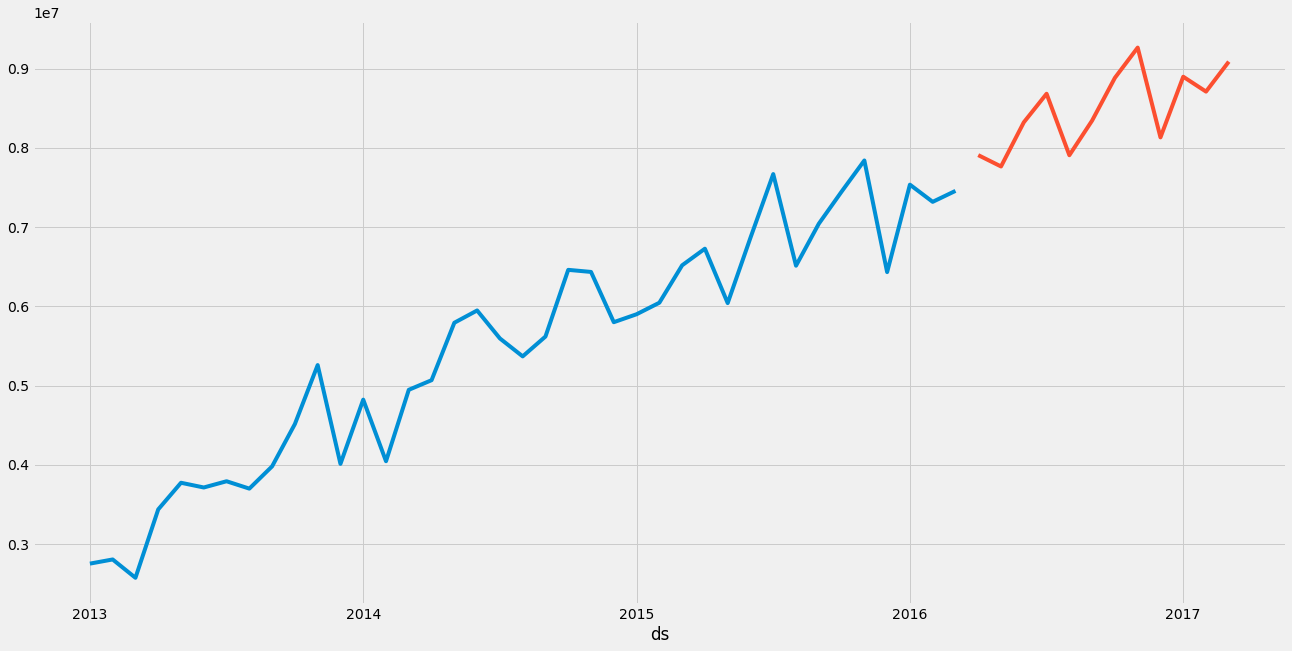

Product_ID :  2    Country :  Columbia


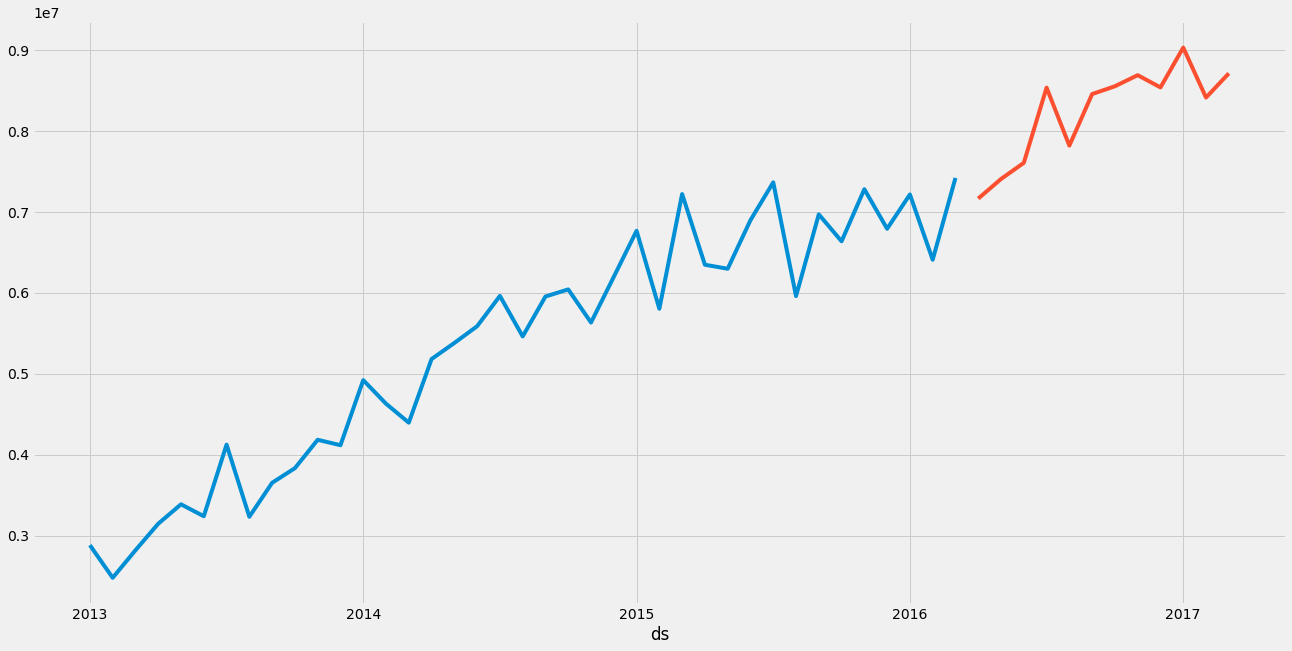

Product_ID :  3    Country :  Argentina


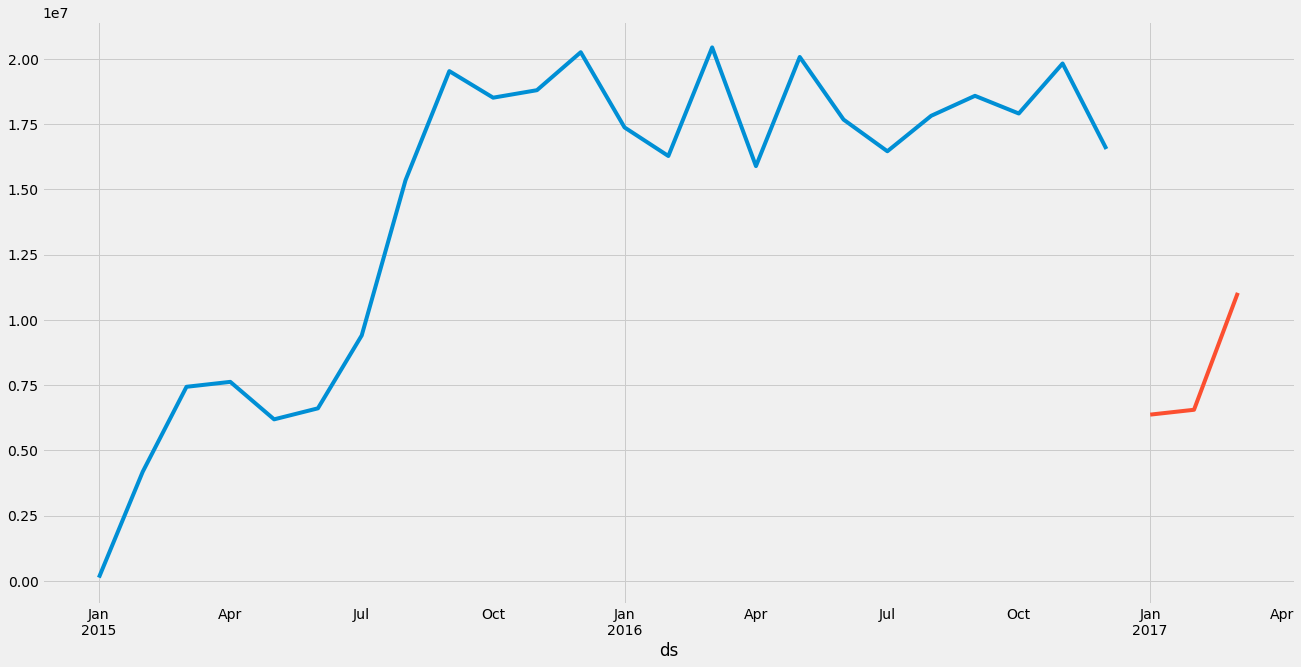

Product_ID :  3    Country :  Columbia


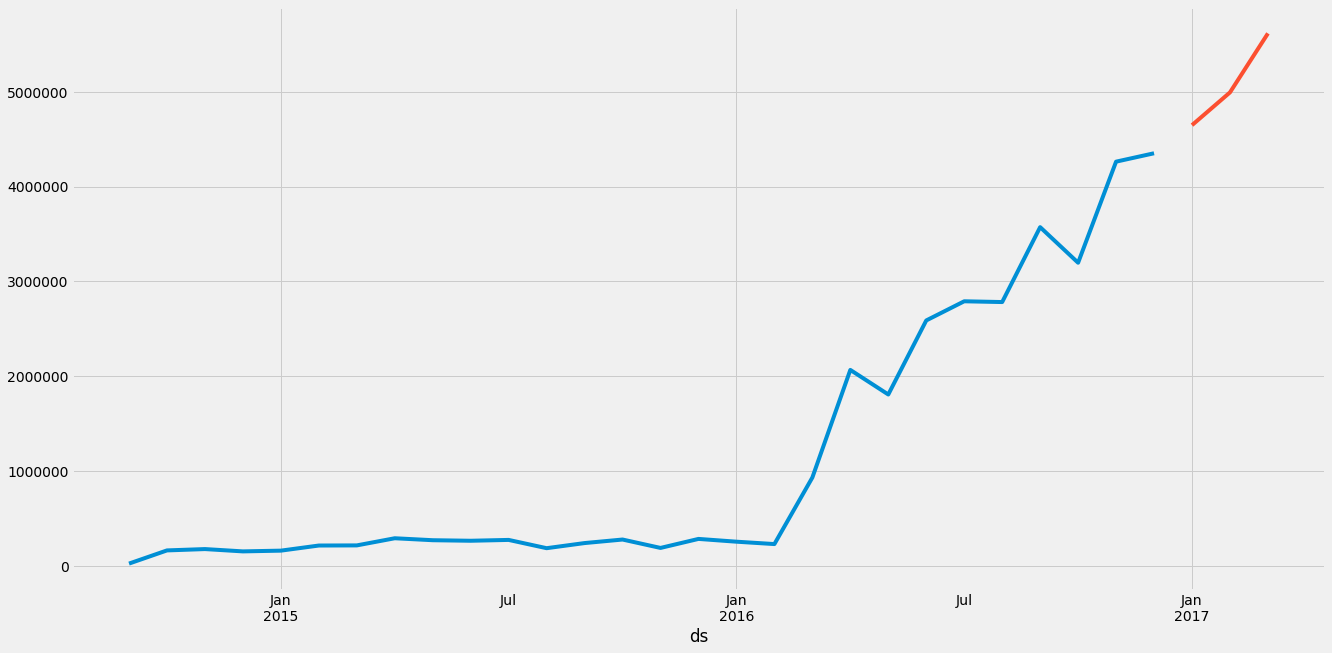

Product_ID :  4    Country :  Finland


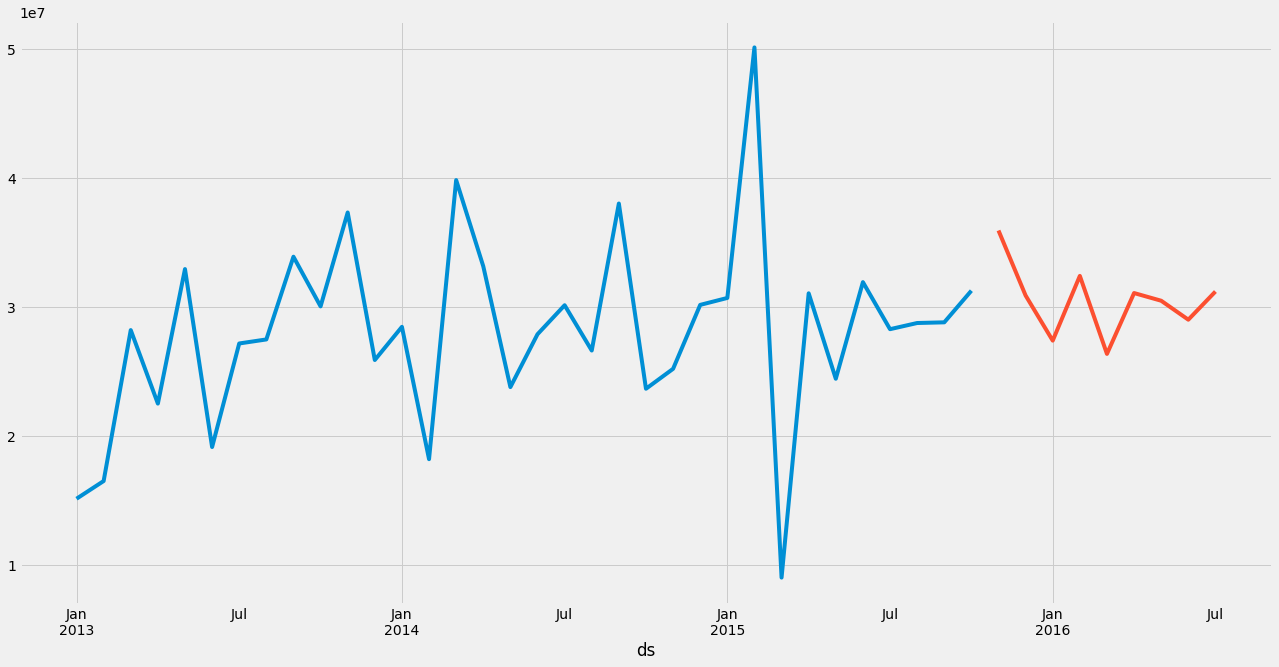

Product_ID :  4    Country :  England


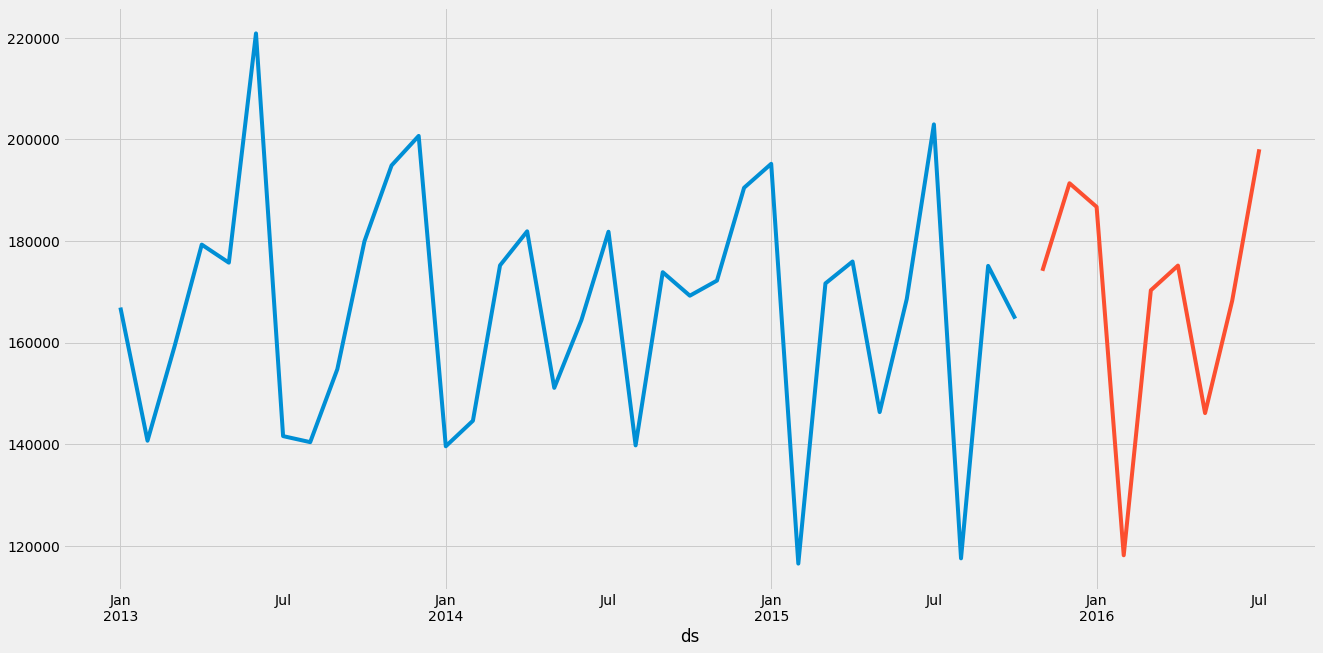

Product_ID :  5    Country :  England


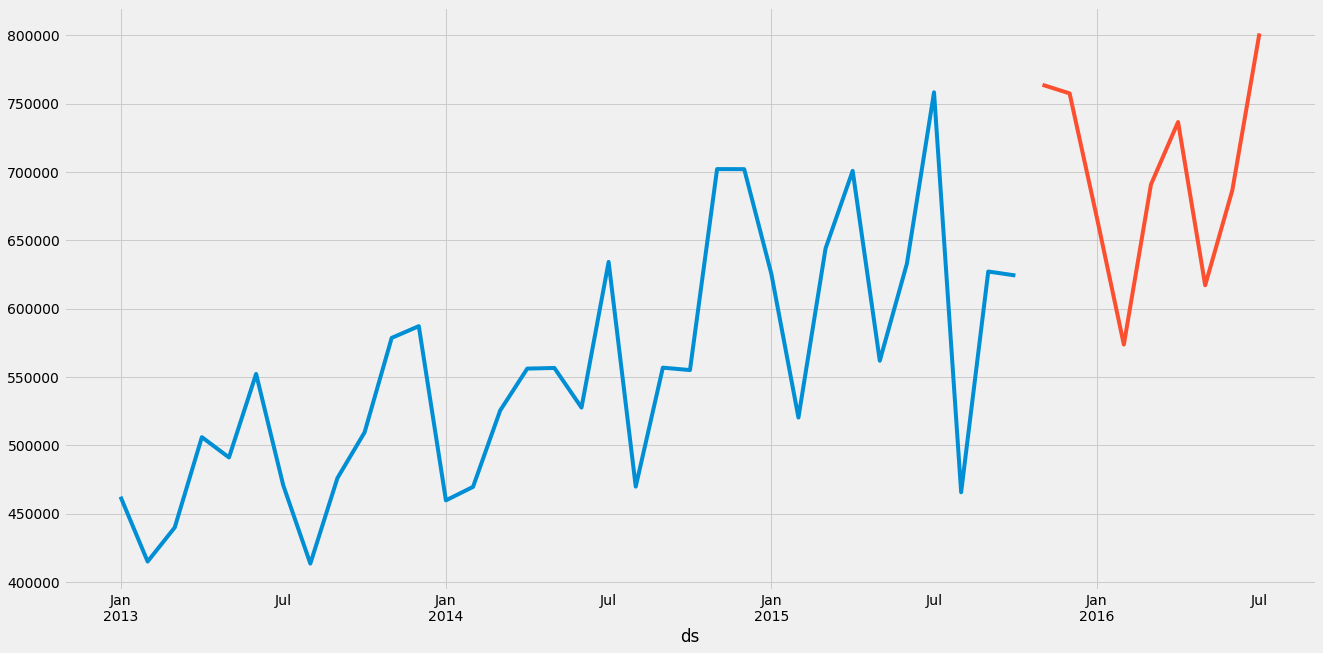

In [37]:
for i in range(1,len(set(train_visual['Product_ID']))+1):
    tmp = list(set(train_visual[train_visual['Product_ID']==i]['Country']))
    for j in tmp:
        print('Product_ID : ',i,'  ','Country : ',j)
        model = ExponentialSmoothing(np.asarray(train_visual[(train_visual['Product_ID']==i)&(train_visual['Country']==j)].sort_values(['ds']).set_index('ds')[['y']].values)
                                     ,seasonal_periods=12 ,trend='add', seasonal='add',).fit()
        forecast = model.forecast(test_visual[(test_visual['Product_ID']==i)&(test_visual['Country']==j)].shape[0])

        df = test_visual[(test_visual['Product_ID']==i)&(test_visual['Country']==j)].sort_values(['ds'])
        df['y'] = np.round(forecast,2)
        train_visual[(train_visual['Product_ID']==i)&(train_visual['Country']==j)].sort_values(['ds']).set_index('ds')['y'].plot(figsize=(20,10))

        df.sort_values(['ds']).set_index('ds')['y'].plot(figsize=(20,10))
        if result.shape[0]>0:
            result = pd.concat([result,df[['S_No','y']]],0)
        else:
            result['S_No'] = df['S_No'].values
            result['y'] = df['y'].values
        plt.show()

In [38]:
result.head()

,S_No,y
0,79073,14649924.76
1,79074,16244242.77
2,79075,17631621.80
3,79076,13912307.23
4,79077,10529398.95


In [39]:
sub = pd.read_csv('Data/yds_test2018.csv')

In [40]:
sub = sub.merge(right=result,on='S_No',how='left')

In [41]:
sub.drop(['Sales'],1,inplace=True)
sub.rename(columns={'y':'Sales'},inplace=True)
sub.head()

,S_No,Year,Month,Product_ID,Country,Sales
0,79073,2016,4,1,Argentina,14649924.76
1,79074,2016,5,1,Argentina,16244242.77
2,79075,2016,6,1,Argentina,17631621.80
3,79076,2016,7,1,Argentina,13912307.23
4,79077,2016,8,1,Argentina,10529398.95


In [42]:
sub.to_csv('holt_winters_best.csv',index=False)

Current best ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:969.4228946259578


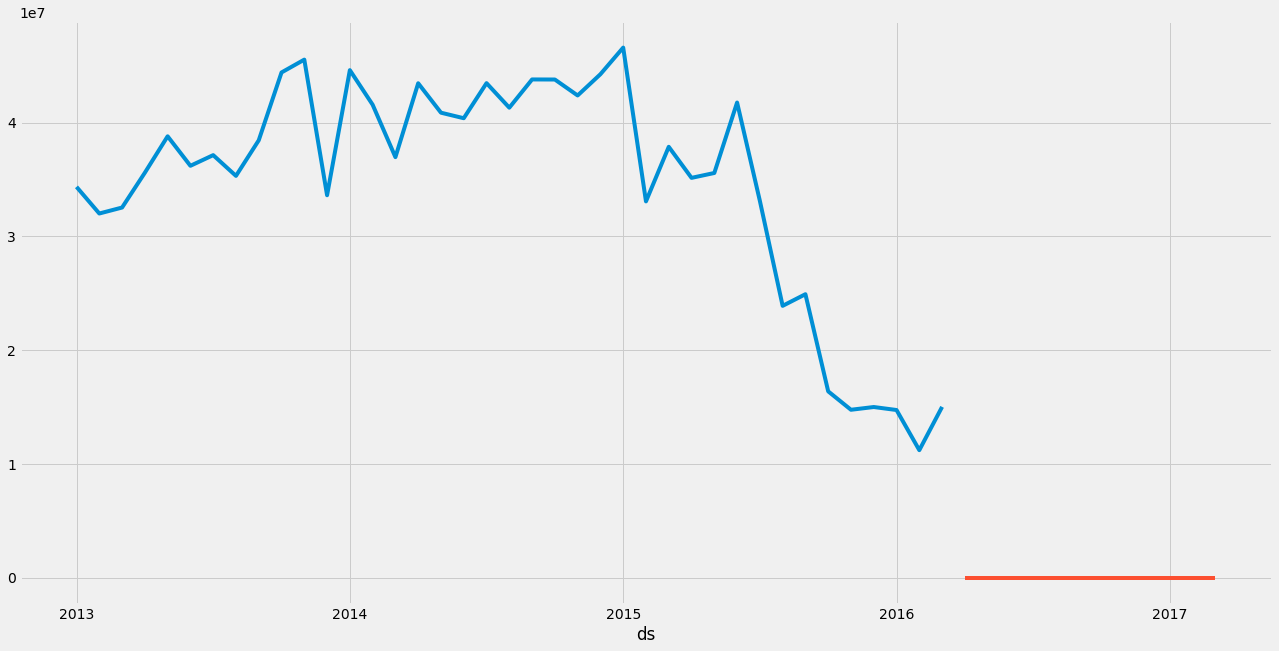

Current best ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:545.4691165175375


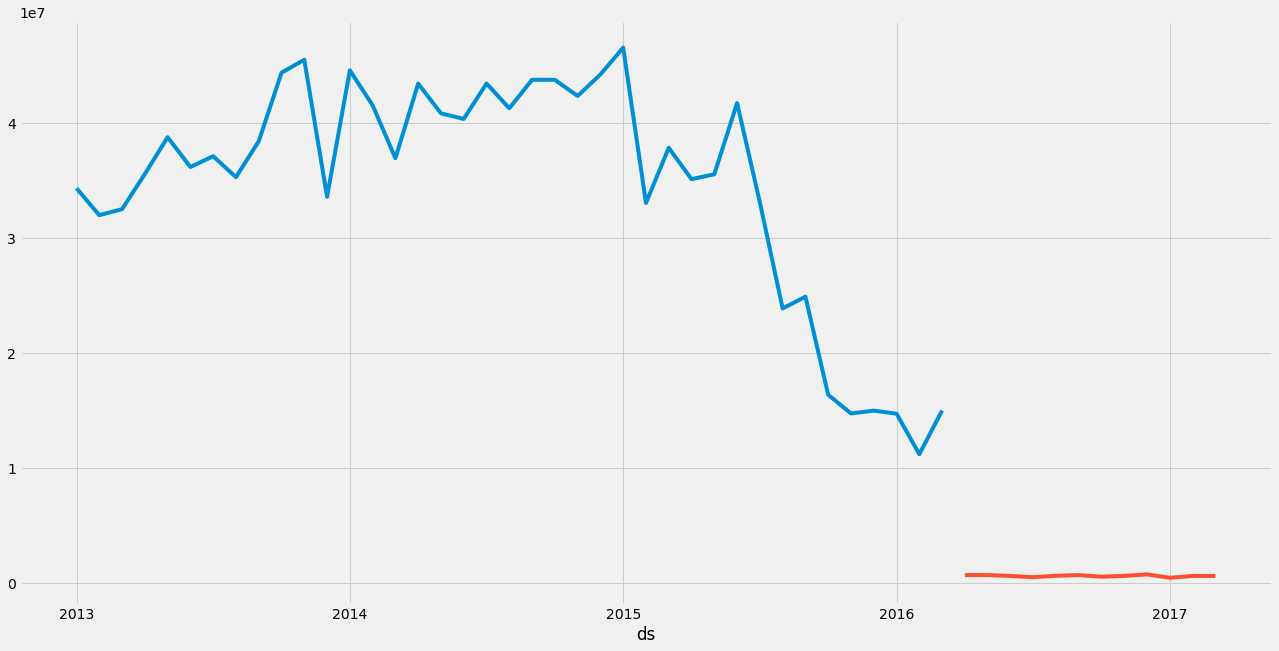

Current best ARIMA(0, 0, 0)x(0, 2, 0, 12)12 - AIC:229.96428289970854


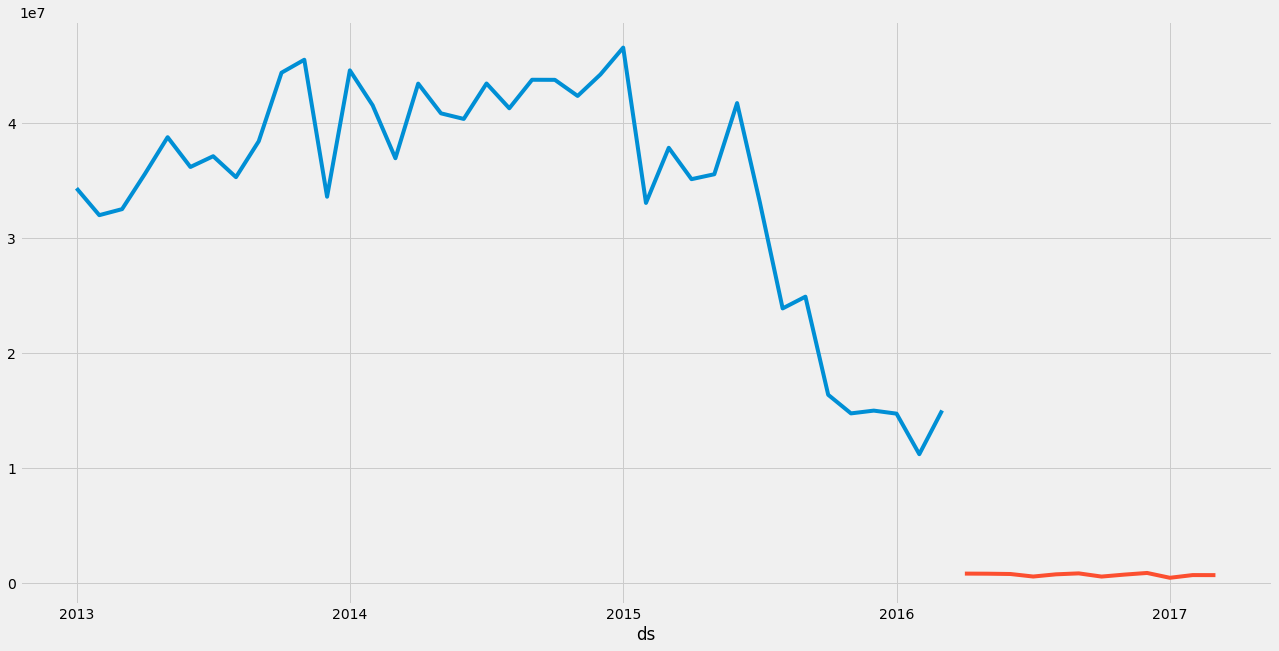

Current best ARIMA(0, 0, 0)x(0, 3, 0, 12)12 - AIC:2.0


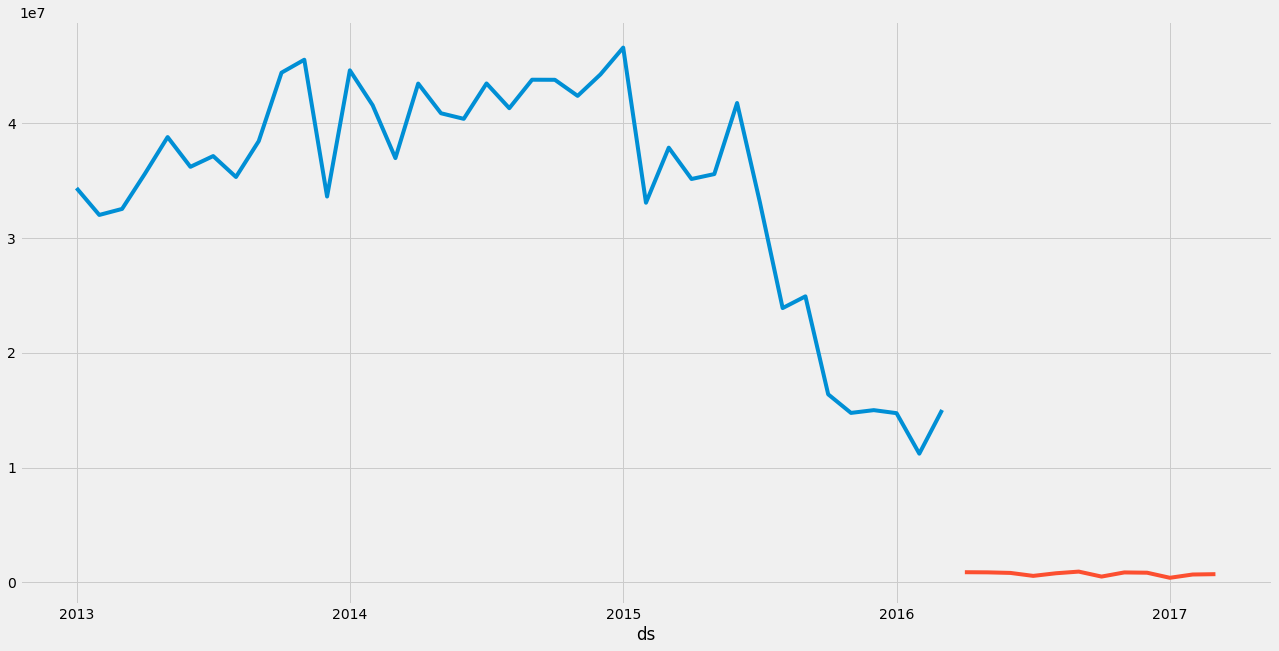

In [ ]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 6)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# print('Examples of parameter combinations for Seasonal ARIMA...')
# print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
# print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
# print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
# print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

warnings.filterwarnings("ignore") # specify to ignore warning messages
best_param, best_param_seasonal,best_aic = None,None,999999999999999999
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_visual[(train_visual['Product_ID']==i)&(train_visual['Country']==j)].sort_values(['ds']).set_index('ds')[['y']],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            if results.aic<best_aic:
                best_aic = results.aic
                best_param = param
                best_param_seasonal = param_seasonal
                print('Current best ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
                # Get forecast 500 steps ahead in future
                pred_uc = results.get_forecast(steps=test_visual[(test_visual['Product_ID']==1)&(test_visual['Country']=='Argentina')].shape[0])

                # Get confidence intervals of forecasts
                pred_ci = pred_uc.conf_int()
                forecast = pred_uc.predicted_mean

                df = test_visual[(test_visual['Product_ID']==1)&(test_visual['Country']=='Argentina')].sort_values(['ds'])
                df['y'] = np.round(forecast.values,2)
                train_visual[(train_visual['Product_ID']==1)&(train_visual['Country']=='Argentina')].sort_values(['ds']).set_index('ds')['y'].plot(figsize=(20,10))

                df.sort_values(['ds']).set_index('ds')['y'].plot(figsize=(20,10))
                plt.show()        
        except:
            continue
            


In [52]:
mod = sm.tsa.statespace.SARIMAX(train_visual[(train_visual['Product_ID']==1)&(train_visual['Country']=='Argentina')].sort_values(['ds']).set_index('ds')[['y']],
                                            order=best_param,
                                            seasonal_order=best_param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

results = mod.fit()
print(results.summary().tables[1])
# results.plot_diagnostics(figsize=(15, 12))
# plt.show()


# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=test_visual[(test_visual['Product_ID']==1)&(test_visual['Country']=='Argentina')].shape[0])

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()
forecast = pred_uc.predicted_mean

df = test_visual[(test_visual['Product_ID']==1)&(test_visual['Country']=='Argentina')].sort_values(['ds'])
df['y'] = np.round(forecast.values,2)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2705     12.786     -0.099      0.921     -26.331      23.790
ar.L2         -2.3499     22.075     -0.106      0.915     -45.617      40.917
ar.L3         -1.3094     30.166     -0.043      0.965     -60.434      57.815
ar.L4         -1.0798     15.536     -0.070      0.945     -31.530      29.370
ma.L1         -1.0165      3.271     -0.311      0.756      -7.428       5.395
ma.L2         -0.4120      6.458     -0.064      0.949     -13.069      12.245
ma.L3         -1.5916     12.983     -0.123      0.902     -27.037      23.854
ar.S.L12      -0.2962     15.150     -0.020      0.984     -29.989      29.397
sigma2      6.973e+13   3.89e-11   1.79e+24      0.000    6.97e+13    6.97e+13


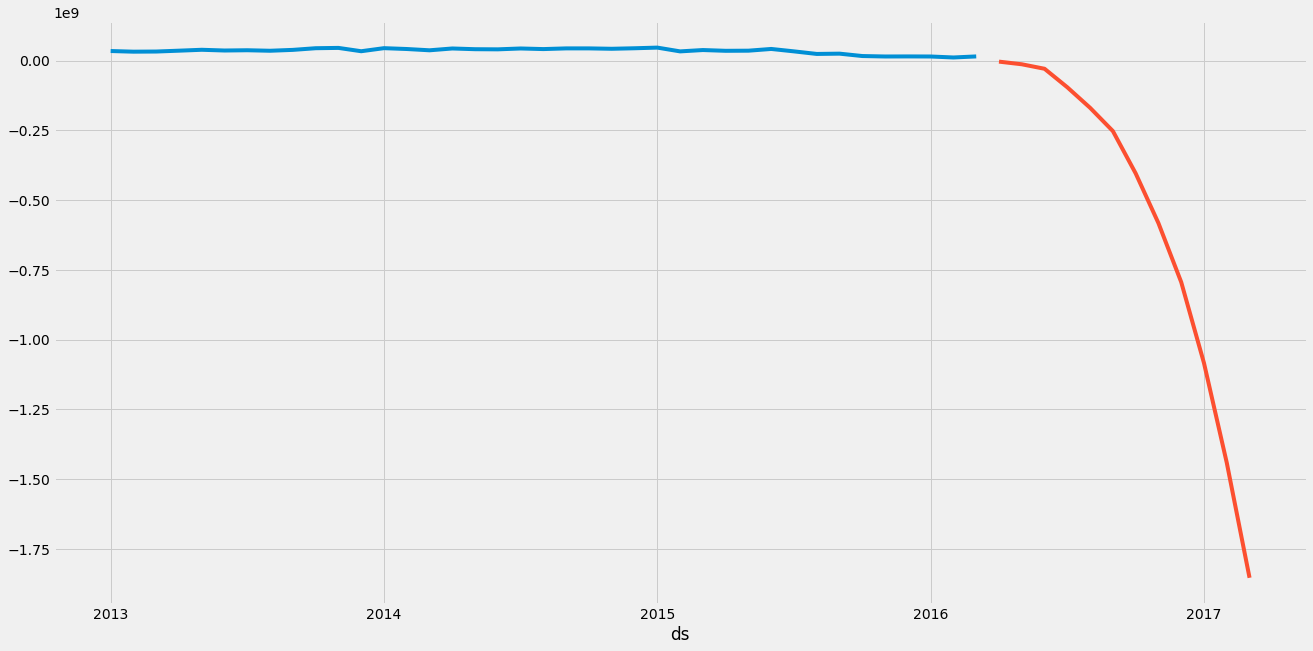

In [53]:
train_visual[(train_visual['Product_ID']==1)&(train_visual['Country']=='Argentina')].sort_values(['ds']).set_index('ds')['y'].plot(figsize=(20,10))
        
df.sort_values(['ds']).set_index('ds')['y'].plot(figsize=(20,10))
plt.show()        

In [21]:
for i in range(1,len(set(train_visual['Product_ID']))+1):
    tmp = list(set(train_visual[train_visual['Product_ID']==i]['Country']))
    for j in tmp:
        print(i,' ',j)
        break

1   Argentina
2   Belgium
3   Argentina
4   England
5   England


In [23]:
test_visual.head()

,S_No,Year,Month,Product_ID,Country,y,ds
0,79073,2016,4,1,Argentina,0,2016-04-01
1,79074,2016,5,1,Argentina,0,2016-05-01
2,79075,2016,6,1,Argentina,0,2016-06-01
3,79076,2016,7,1,Argentina,0,2016-07-01
4,79077,2016,8,1,Argentina,0,2016-08-01
